<a href="https://colab.research.google.com/github/ShambhaviCodes/Big-Data-using-PySpark/blob/main/Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
!wget https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv -O features.csv
!wget https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv -O labels.csv

--2020-11-05 18:54:35--  https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.29.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.29.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20069199 (19M) [text/csv]
Saving to: ‘features.csv’

features.csv        100%[===================>]  19.14M  41.3MB/s    in 0.5s    

2020-11-05 18:54:36 (41.3 MB/s) - ‘features.csv’ saved [20069199/20069199]

--2020-11-05 18:54:36--  https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.29.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.29.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148327 (1.1M) [text/csv]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]   1.09M  6.75MB/s    in 0.2s    

2020-11-05 18:54:36 (6.75 MB

In [4]:
!ls

features.csv  sample_data		 spark-2.4.7-bin-hadoop2.7.tgz
labels.csv    spark-2.4.7-bin-hadoop2.7


In [5]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [6]:
feature = sc.read.csv("features.csv", inferSchema=True, header=True)
label = sc.read.csv("labels.csv", inferSchema=True, header=True)

In [7]:
print(feature.count())
print(feature.columns)
print(label.count())
print(label.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']
59400
['id', 'status_group']


In [8]:
data = feature.join(label, on = 'id')

In [9]:
print(data.count())
print(data.columns)

59400
['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [10]:
print(data.printSchema)
print(data.show(10))

<bound method DataFrame.printSchema of DataFrame[id: int, amount_tsh: double, date_recorded: timestamp, funder: string, gps_height: int, installer: string, longitude: double, latitude: double, wpt_name: string, num_private: int, basin: string, subvillage: string, region: string, region_code: int, district_code: int, lga: string, ward: string, population: int, public_meeting: boolean, recorded_by: string, scheme_management: string, scheme_name: string, permit: boolean, construction_year: int, extraction_type: string, extraction_type_group: string, extraction_type_class: string, management: string, management_group: string, payment: string, payment_type: string, water_quality: string, quality_group: string, quantity: string, quantity_group: string, source: string, source_type: string, source_class: string, waterpoint_type: string, waterpoint_type_group: string, status_group: string]>
+-----+----------+-------------------+-------------------+----------+------------+-----------+-----------

In [11]:
data = data.withColumn('region_code', col('region_code').cast(StringType())).withColumn('district_code', col('district_code').cast(StringType()))

In [12]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- amount_tsh: double (nullable = true)
 |-- date_recorded: timestamp (nullable = true)
 |-- funder: string (nullable = true)
 |-- gps_height: integer (nullable = true)
 |-- installer: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- wpt_name: string (nullable = true)
 |-- num_private: integer (nullable = true)
 |-- basin: string (nullable = true)
 |-- subvillage: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_code: string (nullable = true)
 |-- district_code: string (nullable = true)
 |-- lga: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- public_meeting: boolean (nullable = true)
 |-- recorded_by: string (nullable = true)
 |-- scheme_management: string (nullable = true)
 |-- scheme_name: string (nullable = true)
 |-- permit: boolean (nullable = true)
 |-- construction_year: integer (nullable =

In [13]:
data = data.dropDuplicates(['id'])

In [14]:
print(data.count())

59400


In [15]:
str_cols = [item[0] for item in data.dtypes if item[1].startswith('string')]
for cols in str_cols:
  data = data.withColumn(cols, trim(data[cols]))

In [16]:
agg_row = data.select([count(when(isnan(c), c)).alias(c) for c in data.columns if c not in {'date_recorded', 'public_meeting', 'permit'}]).collect()

In [17]:
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [18]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.4})
print(agg_dict)
print(col_null)
data = data.drop(*col_null)

{'id': 0, 'amount_tsh': 0, 'funder': 0, 'gps_height': 0, 'installer': 0, 'longitude': 0, 'latitude': 0, 'wpt_name': 0, 'num_private': 0, 'basin': 0, 'subvillage': 0, 'region': 0, 'region_code': 0, 'district_code': 0, 'lga': 0, 'ward': 0, 'population': 0, 'recorded_by': 0, 'scheme_management': 0, 'scheme_name': 0, 'construction_year': 0, 'extraction_type': 0, 'extraction_type_group': 0, 'extraction_type_class': 0, 'management': 0, 'management_group': 0, 'payment': 0, 'payment_type': 0, 'water_quality': 0, 'quality_group': 0, 'quantity': 0, 'quantity_group': 0, 'source': 0, 'source_type': 0, 'source_class': 0, 'waterpoint_type': 0, 'waterpoint_type_group': 0, 'status_group': 0}
[]


In [19]:
data.groupBy('recorded_by').count().show()

+--------------------+-----+
|         recorded_by|count|
+--------------------+-----+
|GeoData Consultan...|59400|
+--------------------+-----+



In [20]:
data.groupBy('water_quality').count().orderBy('count', ascending = False).show()

+------------------+-----+
|     water_quality|count|
+------------------+-----+
|              soft|50818|
|             salty| 4856|
|           unknown| 1876|
|             milky|  804|
|          coloured|  490|
|   salty abandoned|  339|
|          fluoride|  200|
|fluoride abandoned|   17|
+------------------+-----+



In [21]:
data = data.drop('recorded_by')

In [22]:
data.groupBy('status_group').pivot('region').sum('amount_tsh').show()

+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|        status_group|   Arusha|Dar es Salaam|Dodoma|   Iringa|Kagera|  Kigoma|       Kilimanjaro|  Lindi| Manyara|    Mara|Mbeya|Morogoro| Mtwara| Mwanza|    Pwani|   Rukwa|   Ruvuma|Shinyanga| Singida|Tabora|   Tanga|
+--------------------+---------+-------------+------+---------+------+--------+------------------+-------+--------+--------+-----+--------+-------+-------+---------+--------+---------+---------+--------+------+--------+
|functional needs ...|  10280.0|          0.0|   0.0| 118400.0|   0.0|270770.0|          129248.0| 3625.0| 71315.0|   900.0|  0.0| 70005.0|36240.0|10000.0|    520.0|292980.0| 125650.0|   2200.0|  6505.0|   0.0|  4310.0|
|          functional|1125485.0|     181175.0|   0.0|5515710.0|   0.0|530725.0|         746942.25|24560.0|312745.0| 9678

In [23]:
print(str_cols)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


In [24]:
for column in str_cols[:2]:
  print(data.groupBy(column).count().orderBy('count', ascending=False).show())
  values_cat = data.groupBy(column).count().collect()
  lessthan = [x[0] for x in values_cat if x[1] < 1000]
  data = data.withColumn(column, when(col(column).isin(lessthan), 'Others').otherwise(col(column)))
  data.groupBy(column).count().orderBy('count', ascending=False).show()

+--------------------+-----+
|              funder|count|
+--------------------+-----+
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          World Bank| 1349|
|                Kkkt| 1287|
|        World Vision| 1246|
|              Unicef| 1057|
|               Tasaf|  877|
|    District Council|  843|
|                 Dhv|  829|
|  Private Individual|  826|
|                Dwsp|  811|
|                   0|  777|
|               Norad|  765|
|     Germany Republi|  610|
|                Tcrs|  602|
|   Ministry Of Water|  590|
|               Water|  583|
+--------------------+-----+
only showing top 20 rows

None
+--------------------+-----+
|              funder|count|
+--------------------+-----+
|              Others|35052|
|Government Of Tan...| 9084|
|                null| 3635|
|              Danida| 3114|
|              Hesawa| 2202|
|               Rwssp| 1374|
|          W

In [25]:
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|         0|21381|
|         1| 7025|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
+----------+-----+
only showing top 20 rows



In [26]:
data = data.withColumn('population', when(col('population') < 2, lit(None)).otherwise(col('population')))
w = Window.partitionBy(data['district_code']) 
data = data.withColumn('population', when(col('population').isNull(), avg(data['population']).over(w)).otherwise(col('population')))
data = data.withColumn('population', ceil(data['population']))
data.groupBy('population').count().orderBy('population').show()

+----------+-----+
|population|count|
+----------+-----+
|      null|   35|
|         2|    4|
|         3|    4|
|         4|   13|
|         5|   44|
|         6|   19|
|         7|    3|
|         8|   23|
|         9|   11|
|        10|  163|
|        11|    7|
|        12|   43|
|        13|   12|
|        14|   18|
|        15|  193|
|        16|    8|
|        17|    6|
|        18|   18|
|        19|    3|
|        20|  462|
+----------+-----+
only showing top 20 rows



In [27]:
color_status = {'functional':'green', 'non functional': 'red', 'functional needs repair' :'blue'}

In [28]:
cols = ['status_group', 'payment_type', 'longitude', 'latitude', 'gps_height']

In [30]:
df = data.select(cols).toPandas()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

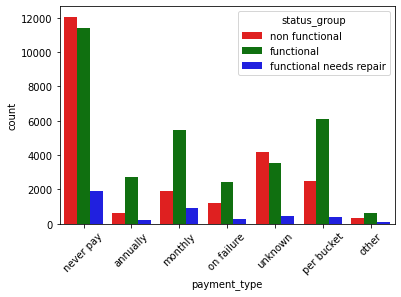

In [33]:
fig, ax = plt.subplots()
sns.countplot(x='payment_type', hue = 'status_group', data=df, ax=ax, palette=color_status)
plt.xticks(rotation=45)

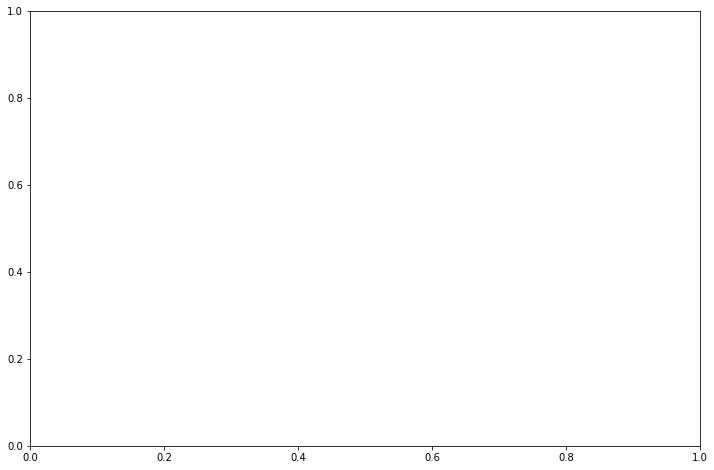

In [35]:
fig.ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='status_group', ax=ax, palette=color_status)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

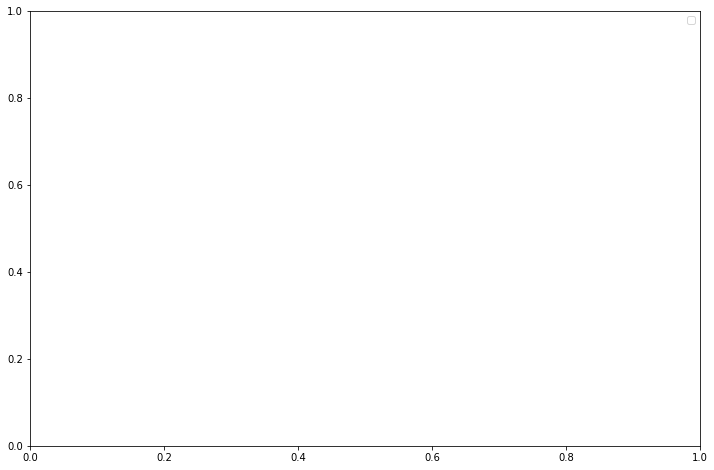

In [36]:
row_functional = (df['status_group'] == 'functional')
row_non_functional = (df['status_group'] == 'non functional')
row_repair = (df['status_group'] == 'functional needs repair')
col = 'gps_height'
fig.ax = plt.subplots(figsize=(12,8))
sns.distplot(df[col][row_functional], color = 'green', label='functional', ax=ax)
sns.distplot(df[col][row_non_functional], color = 'red', label='non functional', ax=ax)
sns.distplot(df[col][row_repair], color = 'blue', label='functional needs repair', ax=ax)
plt.legend()